In [154]:
import pandas as pd

SYMBOL = 'AUD'
TO_SYMBOL = 'JPY'
pair = SYMBOL + TO_SYMBOL
interval = 60
dataframes = []
# pair = "BTCUSD"
# interval = 300
# since = '2019-01-01-00-00'

# df = pd.read_pickle("./data/"+pair +"_"+str(interval) +"_"+ since)

# df = pd.read_csv("./data/"+pair+"_M5.csv", header=0, sep='\t')
# df.columns = [col.lower().replace('<','').replace('>','').strip() for col in df.columns]
# print(df.columns)  # カラム名を確認

# df['close_time'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%Y.%m.%d %H:%M:%S')
# df = df.drop(columns=["date", "time"])

# データを格納するリスト
dataframes = []
# ファイルを読み込む
df = pd.read_csv(pair+".csv", 
                header=None,  # ヘッダーなしの場合
                names=["date", "time", "open", "high", "low", "close", "volumeto"])  # カラム名を指定
# 日付と時間を結合してdatetime型に変換
df['close_time'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%Y.%m.%d %H:%M')
# 必要ない列（dateとtime）を削除
df = df.drop(columns=["date", "time"])
# リストに追加
dataframes.append(df)

# 複数のデータフレームを1つに結合

price_data = pd.concat(dataframes, ignore_index=True)
# リストに追加
dataframes.append(df)
df = pd.concat(dataframes, ignore_index=True)
print(df.head())

     open    high     low   close  volumeto          close_time
0  88.186  88.214  88.186  88.214        33 2022-03-21 05:44:00
1  88.216  88.226  88.214  88.216        25 2022-03-21 05:45:00
2  88.220  88.222  88.208  88.208         8 2022-03-21 05:46:00
3  88.204  88.211  88.204  88.207        18 2022-03-21 05:47:00
4  88.208  88.214  88.207  88.211        19 2022-03-21 05:48:00


In [155]:
import talib as ta
import numpy as np

def _CalcSMAR(df,periods):
    for period in periods:
        df["SMAR_"+str(period)] = ta.EMA(df["close"], period)/df["close"]
    return df

def _CalcRSIR(df,periods):
    for period in periods:
        # ...existing code...
        df["RSIR_"+str(period)] = ta.RSI(df["close"], period)
        df["RSIR_diff_"+str(period)] = df["RSIR_"+str(period)].diff()
    return df
def _CalcOtherR(df,periods):
    for period in periods:
        # ボリンジャーバンド幅
        df['bb_width'+str(period)] = ta.BBANDS(df['close'], period)[1] - ta.BBANDS(df['close'], period)[0]
        df['bb_width_diff_' + str(period)] = df['bb_width'+str(period)].diff()
        # ATR（平均的な値幅）
        df['atr_'+str(period)] = ta.ATR(df['high'], df['low'], df['close'], period)
        df['atr_diff_' + str(period)] = df['atr_'+str(period)].diff()
    # ストキャスティクス
    slowk, slowd = ta.STOCH(df['high'], df['low'], df['close'])
    df['slowk_'+str(period)] = slowk
    df['slowk_diff_'+str(period)] = df['slowk_'+str(period)].diff()
    df['slowd_'+str(period)] = slowd
    df['slowd_diff_'+str(period)] = df['slowd_'+str(period)].diff()
    return df
def get_pip_value(symbol: str) -> float:
    """
    通貨ペアごとに1pipを価格差に換算して返す関数
    symbol : str (例 "USDJPY", "EURUSD", "BTCUSD")
    return : float (1 pip の価格差)
    """
    symbol = symbol.upper()

    # JPYペア
    if "JPY" in symbol and not symbol.startswith("X"):  # XJPYは仮想通貨の例
        return 0.01  # 1 pip = 0.01
    # 一般的なFX主要ペア
    elif any(x in symbol for x in ["USD", "EUR", "GBP", "AUD", "NZD", "CAD", "CHF"]):
        return 0.0001  # 1 pip = 0.0001
    # 仮想通貨（代表的にBTCUSD, ETHUSDは小数点2桁〜3桁程度）
    elif "BTC" in symbol or "ETH" in symbol:
        return 0.1  # 取引所仕様に合わせ調整
    else:
        # デフォルトは 0.0001
        return 0.0001

def make_label(df, horizon=1, spread=0.2, delta=0.5):
    """
    horizon : 何足後を見るか（例:5分足なら5）
    spread  : スプレッド（pips換算）
    delta   : 最低利益マージン
    atr_col : ATRなどボラティリティ列（なければ固定閾値）
    """
    pip_value = get_pip_value(pair)
    pip_value *= spread  # スプレッドを考慮
    theta = pip_value

    diff = df["close"].diff(-1)

    df["target"] = np.where(diff > theta, 1, 
                np.where(diff < -theta, -1, 0))
    return df["target"]
def FeatureExtraction(df):
    df = df.copy()
    periods_RSI = [3, 5, 10]
    periods_SMA = [3, 5, 10]

    df = _CalcSMAR(df, periods_SMA)
    df = _CalcRSIR(df, periods_RSI)
    df = _CalcOtherR(df, periods_RSI)
    window_size = 10

    df["open_r"] = df["open"]/df["close"]
    df["high_r"] = df["high"]/df["close"]
    df["low_r"] = df["low"]/df["close"]

    df["target"] = make_label(df)
    # df = df.drop(columns = ["open", "close", "high", "low", "vol", "spread", "tickvol", "spread"])
    df = df.drop(columns = ["open", "close", "high", "low", "volumeto"])
    # df = df.drop(columns = ["open", "close", "high", "low", "volume"])
    return df

feature_df = FeatureExtraction(df)
print(feature_df.head())
#ラベルの作成
y = feature_df["target"]
# -1, 0, 1 → 0, 1, 2 に変換
y = y.replace({-1: 0, 0: 1, 1: 2})
print("y分布")
print(y.value_counts())
X = feature_df.drop(columns = ["target"])

           close_time    SMAR_3    SMAR_5  SMAR_10     RSIR_3  RSIR_diff_3  \
0 2022-03-21 05:44:00       NaN       NaN      NaN        NaN          NaN   
1 2022-03-21 05:45:00       NaN       NaN      NaN        NaN          NaN   
2 2022-03-21 05:46:00  1.000053       NaN      NaN        NaN          NaN   
3 2022-03-21 05:47:00  1.000032       NaN      NaN  18.181818          NaN   
4 2022-03-21 05:48:00  0.999993  1.000002      NaN  47.058824    28.877005   

   RSIR_5  RSIR_diff_5  RSIR_10  RSIR_diff_10  ...  atr_10  atr_diff_10  \
0     NaN          NaN      NaN           NaN  ...     NaN          NaN   
1     NaN          NaN      NaN           NaN  ...     NaN          NaN   
2     NaN          NaN      NaN           NaN  ...     NaN          NaN   
3     NaN          NaN      NaN           NaN  ...     NaN          NaN   
4     NaN          NaN      NaN           NaN  ...     NaN          NaN   

   slowk_10  slowk_diff_10  slowd_10  slowd_diff_10    open_r    high_r  \
0    

In [156]:
from sklearn.model_selection import train_test_split
#データ分割
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=41)

In [157]:
import catboost as cb
import lightgbm as lgb
import os
import pickle
from sklearn.model_selection import GridSearchCV
# # catboostのインスタンス
# model = cb.CatBoostClassifier(iterations = 3000, learning_rate=0.01)

# model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=5)

# LightGBM用データセット
if 'close_time' in X.columns:
    X = X.drop(columns=['close_time'])
    X_train = X_train.drop(columns=['close_time'])
    X_valid = X_valid.drop(columns=['close_time'])
    X_test = X_test.drop(columns=['close_time'])
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'min_data_in_leaf': 40,
    'lambda_l1': 1.0,
    'lambda_l2': 1.0,
    'verbose': -1
}
eval_result = {}
model = lgb.train(
    params,
    train_data,
    num_boost_round=500,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    callbacks=[lgb.record_evaluation(eval_result)]
)
#モデルの保存
os.makedirs("./Models", exist_ok=True)#モデルを保存しておくためのディレクトリを作成
with open("./Models/"+ pair +"_"+str(interval) + ".pickle", "wb") as f:
    pickle.dump(model, f)

Train Win Rate: 0.6142036000605052
Valid Win Rate: 0.5785869903516963
Test Win Rate: 0.5864693446088795
Entry Count (Test): 4730


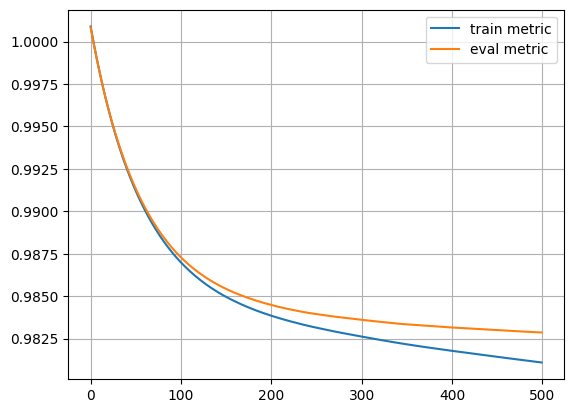

In [158]:
import matplotlib.pyplot as plt

# history = model.get_evals_result()
# # グラフにプロットする
# train_metric = history['learn']['Logloss']
# plt.plot(train_metric, label='train metric')
# eval_metric = history['validation']['Logloss']
# plt.plot(eval_metric, label='eval metric')
from sklearn.metrics import accuracy_score, roc_auc_score
# 予測確率
# # EURUSD
# up_th = 0.515
# down_th = 0.515

# USDJPY
up_th = 0.51
down_th = 0.53

proba_train = model.predict(X_train)  # shape: [n_samples, 3]
proba_valid = model.predict(X_valid)
proba_test  = model.predict(X_test)

# 各クラスの確率
down_proba_train = proba_train[:, 0]
flat_proba_train = proba_train[:, 1]
up_proba_train   = proba_train[:, 2]

down_proba_valid = proba_valid[:, 0]
flat_proba_valid = proba_valid[:, 1]
up_proba_valid   = proba_valid[:, 2]

down_proba_test = proba_test[:, 0]
flat_proba_test = proba_test[:, 1]
up_proba_test   = proba_test[:, 2]

# しきい値でエントリー判定（例：up_th=0.55, down_th=0.35）
entry_train = np.where(up_proba_train >= up_th, 2, np.where(down_proba_train >= down_th, 0, 1))
entry_valid = np.where(up_proba_valid >= up_th, 2, np.where(down_proba_valid >= down_th, 0, 1))
entry_test  = np.where(up_proba_test  >= up_th, 2, np.where(down_proba_test  >= down_th, 0, 1))

# インデックス抽出
train_idx = np.where(entry_train != 1)[0]
valid_idx = np.where(entry_valid != 1)[0]
test_idx  = np.where(entry_test  != 1)[0]

# 勝率計算
hit_train = entry_train[train_idx] == y_train.iloc[train_idx].values
hit_valid = entry_valid[valid_idx] == y_valid.iloc[valid_idx].values
hit_test  = entry_test[test_idx]  == y_test.iloc[test_idx].values

print("Train Win Rate:", np.mean(hit_train))
print("Valid Win Rate:", np.mean(hit_valid))
print("Test Win Rate:", np.mean(hit_test))
print("Entry Count (Test):", np.sum(entry_test != 1))

train_metric = eval_result['train']['multi_logloss']
plt.plot(train_metric, label='train metric')
eval_metric = eval_result['valid']['multi_logloss']
plt.plot(eval_metric, label='eval metric')
plt.legend()
plt.grid()
plt.show()

In [159]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
# テストデータの予測
# Results = pd.concat([pd.DataFrame(model.predict_proba(X_test)[:,1]), y_test.reset_index()], axis = 1)
# Results.columns = ["proba", "closetime", "target"]

# range_th = 0.1
# lower_th = 0.5-range_th
# upper_th = 0.5+range_th
# Results["bins_results"] = Results["proba"].apply(lambda x: 0 if x < lower_th else (1 if x >= upper_th else -1))

# filted_results = Results[(Results["bins_results"] != -1)]
# filted_results["Hit?"] = filted_results["target"] == filted_results["bins_results"]

# print("勝率")
# print(filted_results["Hit?"].sum()/len(filted_results))
# print("予測値ごとの件数（分布）")
# print(Results["bins_results"].value_counts())
# print("エントリー数")
# print(len(filted_results))
# print("エントリー可能ポイント数")
# print(len(Results))
# print("ベッド率(=エントリー数/エントリー可能ポイント数)")
# print(len(filted_results)/(len(Results)))

from sklearn.metrics import accuracy_score
# テストデータの予測
# # EURUSD
# up_th = 0.515
# down_th = 0.515
# USDJPY
up_th = 0.51
down_th = 0.53
proba = model.predict(X_test)

down_proba_test = proba[:, 0]
flat_proba_test = proba[:, 1]
up_proba_test   = proba[:, 2]

# しきい値でエントリー判定（例：up_th=0.55, down_th=0.35）
entry  = np.where(up_proba_test  >= up_th, 2, np.where(down_proba_test  >= down_th, 0, 1))

Results = pd.DataFrame({
    "pred_label": pd.Series(entry),
    "target": y_test.reset_index(drop=True)
})

range_th = 0.1

filted_results = Results[(Results["pred_label"] != 1)]
filted_results["Hit?"] = filted_results["target"] == filted_results["pred_label"]

print("勝率")
print(filted_results["Hit?"].sum() / len(filted_results))
print("予測値ごとの件数（分布）")
print(Results["pred_label"].value_counts())
print("エントリー数")
print(len(filted_results))
print("エントリー可能ポイント数")
print(len(Results))
print("ベッド率(=エントリー数/エントリー可能ポイント数)")
print(len(filted_results) / len(Results))


# ==============================
# 評価
# ==============================
# 全体精度
acc = accuracy_score(y_test, Results["pred_label"])
print(f"Overall Accuracy: {acc:.4f}")

# クラスごとの精度（Precision, Recall, F1, Support）
report = classification_report(
    y_test, Results["pred_label"],
    labels=[0, 1, 2],
    target_names=["Down(-1)", "Flat(0)", "Up(+1)"]
)
print(report)

# 各ラベルの件数
label_counts = pd.Series(y_test).value_counts().sort_index()
print("ラベルごとの件数:")
print(label_counts)


C:\Users\miya4\AppData\Local\Temp\ipykernel_17896\462191668.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filted_results["Hit?"] = filted_results["target"] == filted_results["pred_label"]


勝率
0.5864693446088795
予測値ごとの件数（分布）
pred_label
1    545270
2      2437
0      2293
Name: count, dtype: int64
エントリー数
4730
エントリー可能ポイント数
550000
ベッド率(=エントリー数/エントリー可能ポイント数)
0.0086
Overall Accuracy: 0.1635
              precision    recall  f1-score   support

    Down(-1)       0.60      0.01      0.01    233776
     Flat(0)       0.16      0.99      0.28     87570
      Up(+1)       0.57      0.01      0.01    228654

    accuracy                           0.16    550000
   macro avg       0.44      0.34      0.10    550000
weighted avg       0.52      0.16      0.05    550000

ラベルごとの件数:
target
0    233776
1     87570
2    228654
Name: count, dtype: int64
